In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import LeaveOneGroupOut
import os


dir = os.getcwd()
project_root = os.path.abspath(os.path.join(dir, '..'))
data_root = os.path.join(project_root, 'data')
df = pd.read_csv(filepath_or_buffer=os.path.join(data_root, 'full_f1_data.csv'))

print(df.head())
df["RoundNumber"].nunique()

   DriverNumber  LapTime  LapNumber  SpeedST  TyreLife  TrackTemp  Rainfall  \
0           1.0   96.830        8.0    245.0       8.0       19.1         0   
1           4.0   96.278        8.0    276.0       8.0       19.1         0   
2          81.0   97.251        8.0    257.0       8.0       19.1         0   
3           1.0   94.315        9.0    258.0       9.0       19.1         0   
4           4.0   94.638        9.0    281.0       9.0       19.1         0   

   Position  RoundNumber  FuelLevel  ...  Downforce  CompoundRating  GapAhead  \
0       2.0          1.0       49.0  ...          3               0     0.402   
1       1.0          1.0       49.0  ...          3               0   100.000   
2       3.0          1.0       49.0  ...          3               0     0.635   
3       2.0          1.0       48.0  ...          3               0     0.954   
4       1.0          1.0       48.0  ...          3               0   100.000   

   GapBehind  AvgCorneringSpeed  MaxSp

23

In [3]:
y = df['Target'].values
groups = df['RoundNumber'].values
col_to_drop = ['LapTime', 'DriverNumber', 'RoundNumber', 'LapNumber', 'Target', 'QualiBest']
X = df.drop(columns=col_to_drop, errors='ignore').copy()

cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler()),
])

pre = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_cols),
])

gkf = LeaveOneGroupOut()

In [4]:
models = {
    'RandomForest': (
        Pipeline([('pre', pre),
                  ('model', RandomForestRegressor(random_state=42, n_jobs=1))]),
        {'model__n_estimators': [100, 300],
         'model__max_depth': [5, 10, None]}
    ),

    'XGB': (
        Pipeline([('pre', pre),
                  ('model', XGBRegressor(
                      objective='reg:squarederror',
                      random_state=42,
                      n_jobs=1,
                      tree_method='hist' 
                  ))]),
        {'model__n_estimators': [100, 300],
         'model__learning_rate': [0.05, 0.1],
         'model__max_depth': [3, 6]}
    ),

    'GradientBoostingRegressor': (
        Pipeline([('pre', pre), ('model', GradientBoostingRegressor(random_state=42))]),
        {'model__n_estimators': [100, 300],
         'model__learning_rate': [0.05, 0.1],
         'model__max_depth': [3, 6]}
    )
}

In [5]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import mean_absolute_error
import numpy as np

best_name = None
best_gs = None
best_mae = float("inf")

for name, (pipe, grid) in models.items():
    gs = GridSearchCV(
        pipe,
        grid,
        cv=gkf,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        verbose=1
    )
    gs.fit(X, y, groups=groups)

    cv_mae = -gs.best_score_

    oof = cross_val_predict(gs.best_estimator_, X, y, cv=gkf, groups=groups, n_jobs=-1)
    pred_seconds = oof * df['QualiBest'].values
    cv_mae_seconds = mean_absolute_error(df['LapTime'].values, pred_seconds)

    print(f"{name}: CV MAE (ratio) = {cv_mae:.5f}, CV MAE (s) = {cv_mae_seconds:.3f} s, params = {gs.best_params_}")

    if cv_mae < best_mae:
        best_mae = cv_mae
        best_name = name
        best_gs = gs

print("\nBest model:", best_name, "CV MAE (ratio):", best_mae)

Fitting 23 folds for each of 6 candidates, totalling 138 fits


/Users/taifun/Documents/projects/f1/fastf1-ml-project/.venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForest: CV MAE (ratio) = 0.01774, CV MAE (s) = 1.407 s, params = {'model__max_depth': 10, 'model__n_estimators': 100}
Fitting 23 folds for each of 8 candidates, totalling 184 fits
XGB: CV MAE (ratio) = 0.01613, CV MAE (s) = 1.236 s, params = {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}
Fitting 23 folds for each of 8 candidates, totalling 184 fits
GradientBoostingRegressor: CV MAE (ratio) = 0.01606, CV MAE (s) = 1.237 s, params = {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}

Best model: GradientBoostingRegressor CV MAE (ratio): 0.016055379241964304


In [7]:
oof_preds = cross_val_predict(
    best_gs.best_estimator_,
    X, y,
    cv=gkf,
    groups=groups,
    n_jobs=-1
)

mae = mean_absolute_error(y, oof_preds)
residuals = y - oof_preds
print(f"OOF MAE: {mae:.5f}")

pred_seconds = oof_preds * df['QualiBest'].values
mae_seconds = mean_absolute_error(df['LapTime'].values, pred_seconds)
print(f"OOF MAE (s): {mae_seconds:.3f} s")

OOF MAE: 0.01550
OOF MAE (s): 1.237 s


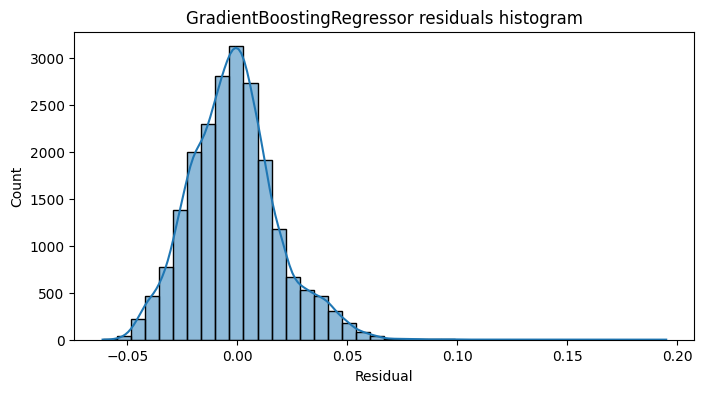

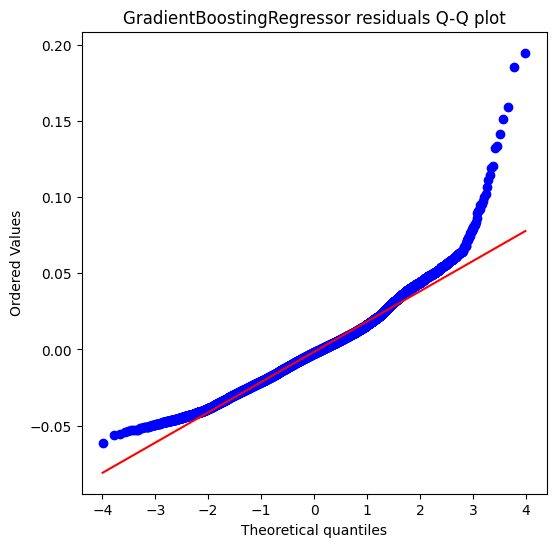

In [8]:
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True, bins=40)
plt.title(f"{best_name} residuals histogram")
plt.xlabel("Residual")
plt.show()

plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(f"{best_name} residuals Q-Q plot")
plt.show()

In [9]:
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

col_to_drop = ['LapTime', 'Target', 'RoundNumber']
train = df.dropna(subset=["Target", "QualiBest", "LapTime", "RoundNumber"]).copy()

X = train.drop(columns=col_to_drop, errors="ignore")
y_ratio = train["Target"].to_numpy()
groups = train["RoundNumber"].to_numpy()

true_sec = train["LapTime"].to_numpy()
qb_all = train["QualiBest"].to_numpy()

logo = LeaveOneGroupOut()

oof_base_sec = np.empty(len(train), dtype=float)

for tr_idx, va_idx in logo.split(X, y_ratio, groups):
    mean_tr = y_ratio[tr_idx].mean()
    qb_va = qb_all[va_idx]
    oof_base_sec[va_idx] = mean_tr * qb_va

print("BASELINE LOGO MAE [s]:", mean_absolute_error(true_sec, oof_base_sec))

model = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
)

oof_model_sec = np.empty(len(train), dtype=float)

for tr_idx, va_idx in logo.split(X, y_ratio, groups):
    m = make_pipeline(
        SimpleImputer(strategy="median"),
        GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        )
    )
    m.fit(X.iloc[tr_idx], y_ratio[tr_idx])
    pred_ratio = m.predict(X.iloc[va_idx])
    oof_model_sec[va_idx] = pred_ratio * qb_all[va_idx]

print("MODEL LOGO MAE [s]:", mean_absolute_error(true_sec, oof_model_sec))

BASELINE LOGO MAE [s]: 2.0138146216791433
MODEL LOGO MAE [s]: 1.2544433608761087
